Bir regresyon problemi için birçok tanım vardır, ancak bizim durumumuzda bunu basitleştireceğiz: bir sayıyı tahmin etmek.

Örneğin, şunları yapmak isteyebilirsiniz:
- Evler hakkında bilgi verilen (oda sayısı, büyüklüğü, banyo sayısı gibi) evlerin satış fiyatını tahmin edin.
- Bir görüntüdeki bir öğenin sınırlayıcı kutusunun koordinatlarını tahmin edin.
- Demografik özelliklerine göre (yaş, cinsiyet, cinsiyet, ırk) bir birey için sağlık sigortası maliyetini tahmin edin.

Bu not defterinde, bir girdi örneğini nasıl alabileceğinizin (bu sizin verilerinizdir), bu girdilerdeki kalıpları keşfetmek için bir sinir ağı oluşturmanın ve sonra bir tahminde bulunmanın (sayı biçiminde) temellerini oluşturacağız. ) bu girdilere dayalıdır.

Özellikle, TensorFlow ile aşağıdakileri yapacağız:

- Bir regresyon modelinin mimarisi
- Giriş şekilleri ve çıkış şekilleri
  - X: özellikler/veriler (girişler)
  - y: etiketler (çıktılar)
- Görüntülemek ve sığdırmak için özel veriler oluşturma
- Modellemedeki adımlar
  - Model oluşturma
  - Model derleme
    - Bir kayıp fonksiyonu tanımlama
    - Optimize edici ayarlama
    - Değerlendirme metrikleri oluşturma
  - Bir model yerleştirme (verilerimizdeki kalıpları bulmasını sağlamak)
- Bir modeli değerlendirmek
  - Modeli görselleştirme ("görselleştirin, görselleştirin, görselleştirin")
  - Eğitim eğrilerine bakmak
  - Tahminleri gerçeklerle karşılaştırın (değerlendirme ölçümlerimizi kullanarak)
- Bir modeli kaydetme (böylece daha sonra kullanabiliriz)
- Model yükleme

Bunların hiçbiri şimdi mantıklı değilse endişelenmeyin, her birinin üzerinden geçeceğiz.

## Regresyon Sinir Ağının Tipik Mimarisi

Tipik kelimesi kasıtlıdır.

Neden?

Çünkü sinir ağları yazmanın birçok farklı yolu vardır (aslında neredeyse sonsuz sayıda yol vardır).

Ancak aşağıdaki, bir sayı koleksiyonunu almak, içlerinde kalıplar bulmak ve ardından bir tür hedef sayı çıktısı almak için genel bir kurulumdur.

Evet, önceki cümle belirsiz ama bunu kısa süre içinde eylemde göreceğiz.

| **Hyperparameter** | **Typical value** |
| --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for # bedrooms, # bathrooms, # car spaces in housing price prediction) |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Output activation | None, ReLU, logistic/tanh |
| Loss function | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) if outliers |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

***Table 1:*** *Typical architecture of a regression network.* ***Source:*** *Adapted from page 293 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Yine, sinir ağları ve genel olarak derin öğrenme konusunda yeniyseniz, yukarıdaki tablonun çoğu bir anlam ifade etmeyecektir. Ama merak etmeyin, yakında hepsini uygulayacağız.

🔑 **Not:** Makine öğrenimindeki bir **hiperparametre**, bir veri analistinin veya geliştiricinin kendilerini ayarlayabileceği bir şeydir; burada **parametre** genellikle bir modelin kendi başına öğrendiği bir şeyi tanımlar (açıkça ayarlanmayan bir değer bir analist tarafından).

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


## Görüntülemek ve Sığdırmak için Veri Oluşturma

Bir regresyon problemi üzerinde çalıştığımız için (bir sayıyı tahmin ederek), modellemek için bazı doğrusal veriler (düz bir çizgi) oluşturalım.

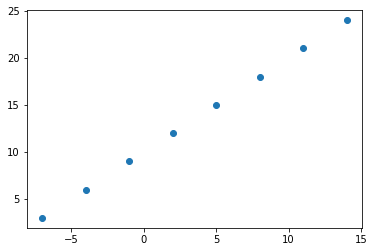

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Özellikler oluştur
X = np.array([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Etiketler oluştur
y = np.array([3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0])

# Görselleştirin
plt.scatter(X, y);

Herhangi bir modelleme yapmadan önce X ile y arasındaki örüntüyü hesaplayabilir misiniz?

Örneğin, bu verilere dayanarak X 17.0 olsaydı y değeri ne olurdu ?

Ya da X -10.0 olsaydı?

Bu tür bir model keşfi, bizim için yapacak sinir ağları inşa edeceğimiz şeyin özüdür.

## Giriş şekilleri ve çıkış şekilleri

Sinir ağları ile çalışırken en önemli kavramlardan biri giriş ve çıkış şekilleridir.

Girdi şekli, modele giren verilerinizin şeklidir.

Çıktı şekli, modelinizden çıkmasını istediğiniz verilerinizin şeklidir.

Bunlar, üzerinde çalıştığınız soruna bağlı olarak farklılık gösterecektir.

Sinir ağları sayıları ve çıktı numaralarını kabul eder. Bu sayılar tipik olarak tensörler (veya diziler) olarak temsil edilir.

Daha önce NumPy dizilerini kullanarak veri oluşturduk, ancak aynısını tensörlerle de yapabilirdik.

In [ ]:
house_info = tf.constant(["bedroom", "bathroom", "garage"])
house_price = tf.constant([939700])
house_info, house_price

(<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'bedroom', b'bathroom', b'garage'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([939700], dtype=int32)>)

In [ ]:
house_info.shape

TensorShape([3])

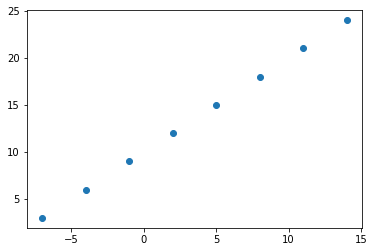

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Özellikler oluşturun (tensör kullanarak)
X = tf.constant([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Etiketler oluşturun (tensörler kullanarak)
y = tf.constant([3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0])

# Görselleştir
plt.scatter(X, y);

Buradaki amacımız, y'yi tahmin etmek için X'i kullanmak olacaktır.

Yani girdimiz X, çıktımız y olacak.

Bunu bilerek, girdi ve çıktı şekillerimiz nasıl olacak sizce?

Hadi bir bakalım.

In [ ]:
# Tek bir X örneği alın
input_shape = X[0].shape 

# y için tek bir örnek alın
output_shape = y[0].shape

# bunların ikisi de skalerdir (şekil yok)
input_shape, output_shape

(TensorShape([]), TensorShape([]))

Bundan, girdilerimizin ve çıktılarımızın şekli yok gibi görünüyor?

Bu nasıl olabildi?

Bunun nedeni, modelimize ne tür veriler ilettiğimiz önemli değil, her zaman girdi olarak alacak ve çıktı olarak bir tür tensör olarak geri dönecektir.

Ancak bizim durumumuzda veri kümemiz nedeniyle (sadece 2 küçük sayı listesi), özel bir tür tensöre bakıyoruz, daha spesifik olarak bir rank 0 tensör veya bir skaler.

In [ ]:
# Tek tek örneklere bir göz atalım
X[0], y[0]

(<tf.Tensor: shape=(), dtype=float32, numpy=-7.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.0>)

Bizim durumumuzda, X[0] eşittir -7.0 ve y[0] eşittir 3.0 arasındaki kalıbı tahmin etmek için bir model oluşturmaya çalışıyoruz.

Şimdi cevabımızı alıyoruz, 1 y değerini tahmin etmek için 1 X değerini kullanmaya çalışıyoruz.

"Bu sadece düz bir çizgiyi tahmin etmek için oldukça karmaşık görünüyor..." diye düşünüyor olabilirsiniz.

Ve haklı olurdun.

Ancak burada ele aldığımız kavramlar, bir modelin girdi ve çıktı şekilleri kavramları temeldir.

Aslında, sinir ağlarıyla çalışırken muhtemelen en çok zaman harcayacağınız iki şey bunlar: girdi ve çıktılarınızın doğru şekilde olduğundan emin olmak.

Şimdi bir anlam ifade etmiyorsa, ileride çok daha fazla örnek göreceğiz (yakında fark edeceksiniz ki girdi ve çıktı şekilleri neredeyse hayal edebileceğiniz her şey olabilir).

![example of input and output shapes for a housing price prediction problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/01-input-and-output-shapes-housing-prices.png)
*Konut fiyatlarını tahmin etmek için bir makine öğrenimi algoritması oluşturmaya çalışıyorsanız, girdileriniz yatak odası sayısı, banyo sayısı ve garaj sayısı olabilir ve size 3 (3 farklı özellik) girdi şekli verir. Ve evin fiyatını tahmin etmeye çalıştığınız için çıktı şekliniz 1 olur.*

## Modellemedeki adımlar
Artık elimizde hangi verilere, girdi ve çıktı şekillerine sahip olduğumuzu biliyoruz, onu modellemek için nasıl bir sinir ağı kuracağımıza bakalım.

TensorFlow'da bir model oluşturmak ve eğitmek için tipik olarak 3 temel adım vardır.

Bir model oluşturma - bir sinir ağının katmanlarını kendiniz bir araya getirin (İşlevsel veya Sıralı API'yi kullanarak) veya önceden oluşturulmuş bir modeli içe aktarın (aktarım öğrenimi olarak bilinir).
Model derleme - bir model performansının nasıl ölçüleceğini (kayıp/metrikler) tanımlamanın yanı sıra nasıl iyileştirileceğini (optimizer) tanımlama.
Model uydurma - modelin verilerdeki kalıpları bulmaya çalışmasına izin vermek (X, y'ye nasıl ulaşır).
Regresyon verilerimiz için bir model oluşturmak üzere Keras Sıralı API'sini kullanarak bunları çalışırken görelim. Ve sonra her birinin üzerinden geçeceğiz.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model using the Sequential API
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.mae, # mae is short for mean absolute error
              optimizer=tf.keras.optimizers.SGD(), # SGD is short for stochastic gradient descent
              metrics=["mae"])

# Fit the model
model.fit(X, y, epochs=5)

Epoch 1/5
1/1 [==============================] - 0s 262ms/step - loss: 11.5048 - mae: 11.5048
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 11.3723 - mae: 11.3723
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 11.2398 - mae: 11.2398
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 11.1073 - mae: 11.1073
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 10.9748 - mae: 10.9748


Boom!

X ve y arasındaki kalıpları bulmak için bir model geliştirdik.

Sizce nasıl gitti?

In [ ]:
# Check out X and y
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

Modelimizi 17.0'lık bir X değerini geçersek sonucun ne olması gerektiğini düşünüyorsunuz?

In [ ]:
# Make a prediction with the model
model.predict([17.0])

array([[12.716021]], dtype=float32)

Pek iyi gitmiyor... 27.0'a yakın bir çıktı vermeliydi.

> **Soru:** Keras nedir? TensorFlow ile çalıştığımızı sanıyordum ama TensorFlow kodunu her yazdığımızda keras tf'den sonra geliyor (ör. tf.keras.layers.Dense())?

TensorFlow 2.0+'dan önce Keras, derin öğrenme modellerini kolaylıkla oluşturabilmek için tasarlanmış bir API idi. TensorFlow 2.0+'dan bu yana, işlevselliği TensorFlow kitaplığına sıkı bir şekilde entegre edilmiştir.



## Bir Modeli Geliştirmek


Mevcut modelimizi nasıl geliştireceğinizi düşünüyorsunuz?

Yukarıda yaptığımız şeylerden bazılarını ince ayar yaparak tahmin ettiyseniz, haklısınız.

Modelimizi geliştirmek için daha önce geçtiğimiz 3 adımın neredeyse her bölümünü değiştiriyoruz.

1. **Bir model oluşturma**<br> - burada daha fazla katman eklemek, her katmandaki gizli birimlerin (nöronlar olarak da adlandırılır) sayısını artırmak, her katmanın etkinleştirme işlevlerini değiştirmek isteyebilirsiniz.
2. **Bir model derleme**<br> - optimizasyon fonksiyonunu seçmek veya belki de optimizasyon fonksiyonunun öğrenme oranını değiştirmek isteyebilirsiniz.
- **Bir model yerleştirme**<br> - belki de bir modeli daha fazla dönem için (daha uzun süre eğitime bırakın) veya daha fazla veri için (modele öğrenmek için daha fazla örnek verin) sığdırabilirsiniz.

Vay. Az önce bir dizi olası adımı tanıttık. Hatırlanması gereken önemli şey, bunların her birini nasıl değiştireceğiniz, üzerinde çalıştığınız soruna bağlı olacaktır.

İşin iyi yanı, önümüzdeki birkaç problemde, hepsine elimizi uzatacağız.

Şimdilik, basit tutalım, tek yapacağımız modelimizi daha uzun süre eğitmek (diğer her şey aynı kalacak).

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as above)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile model (same as above)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# Fit model (this time we'll train for longer)
model.fit(X, y, epochs=100) # train for 100 epochs not 10

Epoch 1/100
1/1 [==============================] - 0s 252ms/step - loss: 11.5048 - mae: 11.5048
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 11.3723 - mae: 11.3723
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 11.2398 - mae: 11.2398
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 11.1073 - mae: 11.1073
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 10.9748 - mae: 10.9748
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 10.8423 - mae: 10.8423
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 10.7098 - mae: 10.7098
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 10.5773 - mae: 10.5773
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 10.4448 - mae: 10.4448
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 10.3123 - mae: 10.3123
Epoch 11/100
1/1 [==============================] - 0s 6m

Daha önce kayıp değerinin düştüğünü fark etmiş olabilirsiniz (ve dönem sayısı yükseldikçe azalmaya devam edin).

Modelimizle bir tahmin yaptığımızda bunun ne anlama geldiğini düşünüyorsunuz?

17.0'ı tekrar tahmin etmeye çalışsak nasıl olur?

In [ ]:
# Remind ourselves of what X and y are
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [ ]:
# Try and predict what y would be if X was 17.0
model.predict([17.0]) # the right answer is 27.0 (y = X + 10)

array([[30.158512]], dtype=float32)

Çok daha iyi!

Bu sefer yaklaştık. Ama yine de daha iyi olabilirdik.

Şimdi bir model yetiştirdik, nasıl değerlendirebiliriz?

## Bir modeli değerlendirmek

Sinir ağları oluştururken geçeceğiniz tipik bir iş akışı:

```
Build a model -> evaluate it -> build (tweak) a model -> evaulate it -> build (tweak) a model -> evaluate it...
```

İnce ayar, belki de sıfırdan bir model oluşturmaktan değil, mevcut olanı ayarlamaktan geliyor.

### Görselleştirin, görselleştirin, görselleştirin

Değerlendirme söz konusu olduğunda, şu kelimeleri hatırlamak isteyeceksiniz: "görselleştir, görselleştir, görselleştir."

Bunun nedeni, muhtemelen bir şeye (yapmaya) bir şey hakkında düşünmekten daha iyi bakıyor olmanızdır.

Şunları görselleştirmek iyi bir fikirdir:

- Veriler - hangi verilerle çalışıyorsunuz? Nasıl görünüyor?
- Modelin kendisi - mimari neye benziyor? Farklı şekiller nelerdir?
- Bir modelin eğitimi - bir model öğrenirken nasıl performans gösterir?
- Bir modelin tahminleri - bir modelin tahminleri temel gerçeğe (orijinal etiketler) karşı nasıl sıralanır?

Modeli görselleştirerek başlayalım.

Ama önce, biraz daha büyük bir veri kümesi ve kullanabileceğimiz yeni bir model oluşturacağız (öncekiyle aynı olacak, ancak ne kadar çok pratik o kadar iyi).

In [ ]:
# Make a bigger dataset
X = np.arange(-100, 100, 4)
X

array([-100,  -96,  -92,  -88,  -84,  -80,  -76,  -72,  -68,  -64,  -60,
        -56,  -52,  -48,  -44,  -40,  -36,  -32,  -28,  -24,  -20,  -16,
        -12,   -8,   -4,    0,    4,    8,   12,   16,   20,   24,   28,
         32,   36,   40,   44,   48,   52,   56,   60,   64,   68,   72,
         76,   80,   84,   88,   92,   96])

In [ ]:
# Make labels for the dataset (adhering to the same pattern as before)
y = np.arange(-90, 110, 4)
y

array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

`y=X+10` olduğundan, etiketleri şöyle de yapabiliriz:

In [ ]:
# Same result as above
y = X + 10
y

array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

### Verileri eğitim/test setine ayırın

Bir makine öğrenimi projesindeki diğer en yaygın ve önemli adımlardan biri, bir eğitim ve test seti (ve gerektiğinde bir doğrulama seti) oluşturmaktır.

Her set belirli bir amaca hizmet eder:

- **Eğitim seti**<br> - model, genellikle mevcut toplam verilerin (dönem boyunca çalıştığınız ders materyalleri gibi) %70-80'i olan bu verilerden öğrenir.
- **Doğrulama seti**<br> - model, genellikle mevcut toplam verilerin %10-15'i olan bu verilere göre ayarlanır (final sınavından önce girdiğiniz alıştırma sınavı gibi).
- **Test seti**<br> - model, öğrendiklerini test etmek için bu veriler üzerinde değerlendirilir, genellikle mevcut toplam verilerin %10-15'i kadardır (dönem sonunda girdiğiniz final sınavı gibi).

Şimdilik sadece bir eğitim ve test seti kullanacağız, bu, modelimizin öğrenilmesi ve değerlendirilmesi için bir veri setimiz olacağı anlamına geliyor.

X ve y dizilerimizi bölerek bunları oluşturabiliriz.

> 🔑 Not: Gerçek dünya verileriyle uğraşırken, bu adım tipik olarak bir projenin hemen başlangıcında yapılır (test seti her zaman diğer tüm verilerden ayrı tutulmalıdır). Modelimizin eğitim verilerini öğrenmesini ve ardından görünmeyen örneklere ne kadar iyi genelleştiğine dair bir gösterge elde etmek için test verileri üzerinde değerlendirmesini istiyoruz.

In [ ]:
# Check how many samples we have
len(X)

50

In [ ]:
# Split data into train and test sets
X_train = X[:40] # first 40 examples (80% of data)
y_train = y[:40]

X_test = X[40:] # last 10 examples (20% of data)
y_test = y[40:]

len(X_train), len(X_test)

(40, 10)

### Verileri görselleştirme
Artık eğitim ve test verilerimiz var, onu görselleştirmek iyi bir fikir.

Neyin ne olduğunu ayırt etmek için güzel renklerle çizelim.

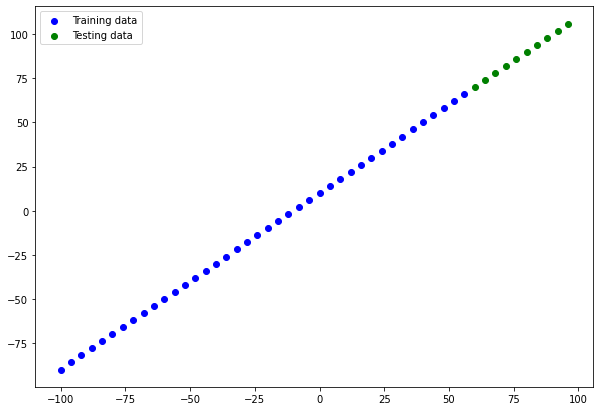

In [ ]:
plt.figure(figsize=(10, 7))
# Plot training data in blue
plt.scatter(X_train, y_train, c='b', label='Training data')
# Plot test data in green
plt.scatter(X_test, y_test, c='g', label='Testing data')
# Show the legend
plt.legend();

Güzel! Verilerinizi, modelinizi, herhangi bir şeyi görselleştirebildiğiniz her an, bu iyi bir fikirdir.

Bu grafiği göz önünde bulundurarak, yeşil noktaları (X_test) çizmek için mavi noktalardaki (X_train) deseni öğrenen bir model oluşturmaya çalışacağız.

Bir model oluşturma zamanı. Daha öncekinin aynısını yapacağız (daha uzun süre eğittiğimiz).

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as above)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile model (same as above)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# Fit model (same as above)
#model.fit(X_train, y_train, epochs=100) # commented out on purpose (not fitting it just yet)

### Modeli görselleştirme

Bir model oluşturduktan sonra, ona bir göz atmak isteyebilirsiniz (özellikle daha önce çok model oluşturmadıysanız).

Modelinizin katmanlarını ve şekillerini, üzerinde Summary()'i arayarak inceleyebilirsiniz.

🔑 Not: Bir modeli görselleştirmek, özellikle girdi ve çıktı şekli uyumsuzluklarıyla karşılaştığınızda faydalıdır.

In [ ]:
# Doesn't work (model not fit/built)
model.summary()

ValueError: ignored

Ahh, yukarıdaki hücre hata veriyor çünkü inşa ettiğimiz modele uymadık.

Ayrıca, hangi girdi şeklini beklemesi gerektiğini de söylemedik.

Yukarıda hatırlayın, giriş şeklini nasıl tartıştık sadece bir sayı mı?

İlk katmana input_shape parametresini kullanarak verilerimizin girdi şeklini modelimize bildirebiliriz (genellikle input_shape tanımlı değilse, Keras bunu otomatik olarak bulmaya çalışır).

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as above)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_shape=[1]) # define the input_shape to our model
])

# Compile model (same as above)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

In [ ]:
# This will work after specifying the input shape
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Modelimizde `summary()` işlevini çağırmak bize içerdiği katmanları, çıktı şeklini ve parametre sayısını gösterir.

- **Toplam parametreler**<br> - modeldeki toplam parametre sayısı.
- **Eğitilebilir parametreler**<br> - bunlar, modelin eğitirken güncelleyebileceği parametrelerdir (kalıplardır).
- **Eğitilemez parametreler**<br> - bu parametreler eğitim sırasında güncellenmez (bu, aktarım öğrenimi sırasında diğer modellerden önceden öğrenilmiş kalıpları getirdiğinizde tipiktir).

> 📖 Kaynak: Bir katmandaki eğitilebilir parametrelere daha derinlemesine bir genel bakış için MIT'nin derin öğrenme videosuna girişine göz atın.

> 🛠 Alıştırma: Dense katmandaki gizli birimlerin sayısıyla oynamayı deneyin (örn. `Dense(2)`, `Dense(3)`). Bu, Toplam/Eğitilebilir parametreleri nasıl değiştirir? Değişikliğe neyin sebep olduğunu araştırın.

Şimdilik, bu parametreler hakkında düşünmeniz gereken tek şey, bunların verilerdeki öğrenilebilir kalıplarıdır.

Modelimizi eğitim verilerine uyduralım.

In [ ]:
# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, verbose=0) # verbose controls how much gets output

In [ ]:
# Check the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Özetin yanı sıra, `plot_model()` kullanarak modelin 2B grafiğini de görüntüleyebilirsiniz.

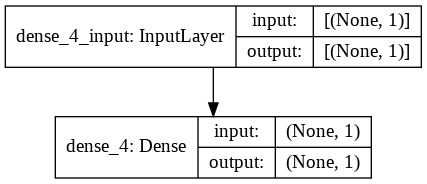

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

Bizim durumumuzda, kullandığımız modelin yalnızca bir girdisi ve bir çıktısı var, ancak daha karmaşık modelleri görselleştirmek hata ayıklama için çok yardımcı olabilir.

### Tahminleri görselleştirme

Şimdi eğitimli bir modelimiz var, hadi bazı tahminleri görselleştirelim.

Tahminleri görselleştirmek için, onları temel gerçek etiketlerine göre planlamak her zaman iyi bir fikirdir.

Bunu genellikle y_test ve y_pred (temel gerçek ve tahminler) şeklinde görürsünüz.

İlk olarak, test verileri (X_test) üzerinde bazı tahminler yapacağız, modelin test verilerini hiç görmediğini unutmayın.

In [ ]:
# Make predictions
y_preds = model.predict(X_test)

In [ ]:
# View the predictions
y_preds

array([[53.57109 ],
       [57.05633 ],
       [60.541573],
       [64.02681 ],
       [67.512054],
       [70.99729 ],
       [74.48254 ],
       [77.96777 ],
       [81.45301 ],
       [84.938255]], dtype=float32)

Tamam, bir sayı listesi alıyoruz ama bunlar temel doğruluk etiketleriyle nasıl karşılaştırılır?

Bunu bulmak için bir çizim fonksiyonu oluşturalım.

🔑 Not: Bir şeyi çok fazla görselleştireceğinizi düşünüyorsanız, daha sonra kullanabilmek için onu işlevsel hale getirmek iyi bir fikirdir.

In [ ]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=y_preds):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))
  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", label="Training data")
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", label="Testing data")
  # Plot the predictions in red (predictions were made on the test data)
  plt.scatter(test_data, predictions, c="r", label="Predictions")
  # Show the legend
  plt.legend();

NameError: ignored

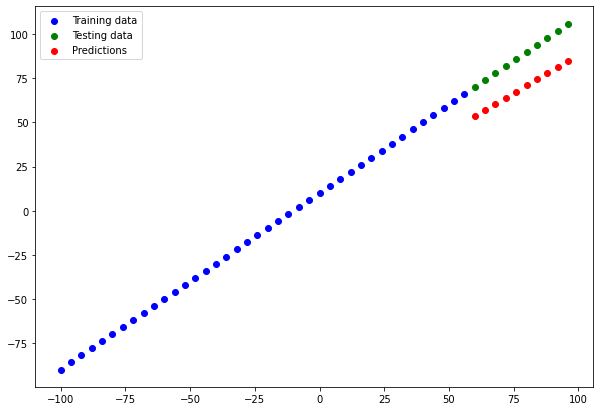

In [ ]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_preds)

Konudan, tahminlerimizin tamamen tuhaf olmadığını görebiliyoruz ama kesinlikle özel bir şey de değiller.

### Tahminleri Değerlendirme

Görselleştirmelerin yanı sıra değerlendirme metrikleri, modelinizi değerlendirmek için alternatif en iyi seçeneğinizdir.

Üzerinde çalıştığınız soruna bağlı olarak, farklı modellerin farklı değerlendirme ölçütleri vardır.

Regresyon problemleri için kullanılan ana metriklerden ikisi şunlardır:

- **Mean absolute error (MAE)**<br> - tahminlerin her biri arasındaki ortalama fark.
- **Mean squared error (MSE)**<br> - tahminler arasındaki kare ortalama fark (daha büyük hatalar küçük hatalardan daha zararlıysa kullanın).

Bu değerlerin her biri ne kadar düşükse, o kadar iyidir.

Ayrıca, derleme adımı sırasında herhangi bir ölçüm ayarının yanı sıra modelin kaybını döndürecek olan `model.evaluate()` öğesini de kullanabilirsiniz.

In [ ]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 116ms/step - loss: 18.7453 - mae: 18.7453


[18.74532699584961, 18.74532699584961]

Bizim durumumuzda, kayıp işlevi için MAE'yi ve metrikler için MAE'yi kullandığımızdan, model.evaulate() her ikisini de döndürür.

TensorFlow ayrıca MSE ve MAE için yerleşik işlevlere sahiptir.

Birçok değerlendirme işlevi için öncül aynıdır: tahminleri temel gerçek etiketleriyle karşılaştırın.

In [ ]:
# Calculate the mean absolute error
mae = tf.metrics.mean_absolute_error(y_true=y_test, 
                                     y_pred=y_preds)
mae

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([34.42891 , 30.943668, 27.45843 , 23.97319 , 20.487946, 17.202168,
       14.510478, 12.419336, 11.018796, 10.212349], dtype=float32)>

ha? Bu garip, MAE tek bir çıktı olmalı.

Bunun yerine 10 değer alırız.

Bunun nedeni, y_test ve y_preds tensörlerimizin farklı şekillerde olmasıdır.

In [ ]:
# Check the test label tensor values
y_test

array([ 70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

In [ ]:
# Check the predictions tensor values (notice the extra square brackets)
y_preds

array([[53.57109 ],
       [57.05633 ],
       [60.541573],
       [64.02681 ],
       [67.512054],
       [70.99729 ],
       [74.48254 ],
       [77.96777 ],
       [81.45301 ],
       [84.938255]], dtype=float32)

In [ ]:
# Check the tensor shapes
y_test.shape, y_preds.shape

((10,), (10, 1))

Farklı girdi ve çıktı şekilleriyle nasıl başa çıkacağımızı tartıştığımızı unutmayın, karşılaşacağınız en yaygın sorunlardan biridir, bu o zamanlardan biridir.

Ama endişelenme.

`squeeze()` kullanarak düzeltebiliriz, 1 boyutunu y_preds tensörümüzden kaldıracak ve onu y_test ile aynı şekle getirecektir.

> 🔑 Not: İki tensörü karşılaştırıyorsanız, bunların doğru shape olduklarından emin olmak önemlidir (shape her zaman manipüle etmeniz gerekmeyecek, ancak her zaman dikkatli olun, birçok hata bunun sonucudur. uyumsuz tensörler, özellikle uyumsuz giriş ve çıkış shape).

In [ ]:
# Shape before squeeze()
y_preds.shape

(10, 1)

In [ ]:
# Shape after squeeze()
y_preds.squeeze().shape

(10,)

In [ ]:
# What do they look like?
y_test, y_preds.squeeze()

(array([ 70,  74,  78,  82,  86,  90,  94,  98, 102, 106]),
 array([53.57109 , 57.05633 , 60.541573, 64.02681 , 67.512054, 70.99729 ,
        74.48254 , 77.96777 , 81.45301 , 84.938255], dtype=float32))

Tamam, şimdi y_test ve y_preds tenorlarımızı nasıl aynı şekle getireceğimizi biliyoruz, hadi değerlendirme metriklerimizi kullanalım.

In [ ]:
# Calcuate the MAE
mae = tf.metrics.mean_absolute_error(y_true=y_test, 
                                     y_pred=y_preds.squeeze()) # use squeeze() to make same shape
mae

<tf.Tensor: shape=(), dtype=float32, numpy=18.745327>

In [ ]:
# Calculate the MSE
mse = tf.metrics.mean_squared_error(y_true=y_test,
                                    y_pred=y_preds.squeeze())
mse

<tf.Tensor: shape=(), dtype=float32, numpy=353.57336>

MAE'yi saf TensorFlow işlevlerini kullanarak da hesaplayabiliriz.

In [ ]:
# Returns the same as tf.metrics.mean_absolute_error()
tf.reduce_mean(tf.abs(y_test-y_preds.squeeze()))

<tf.Tensor: shape=(), dtype=float64, numpy=18.745327377319335>

Yine, tekrar kullanabileceğinizi (veya kendinizi tekrar tekrar kullanırken bulabileceğinizi) düşündüğünüz herhangi bir şeyi işlevsel hale getirmek iyi bir fikirdir.

Değerlendirme metriklerimiz için fonksiyonlar yapalım.

In [ ]:
def mae(y_test, y_pred):
  """
  Calculuates mean absolute error between y_test and y_preds.
  """
  return tf.metrics.mean_absolute_error(y_test,
                                        y_pred)
  
def mse(y_test, y_pred):
  """
  Calculates mean squared error between y_test and y_preds.
  """
  return tf.metrics.mean_squared_error(y_test,
                                       y_pred)

### Bir modeli geliştirmek için deneyler çalıştırma

Değerlendirme metriklerini ve modelinizin yaptığı tahminleri gördükten sonra, muhtemelen onu geliştirmek isteyeceksiniz.

Yine, bunu yapmanın birçok farklı yolu vardır, ancak bunlardan başlıca 3 tanesi şunlardır:

- **Daha fazla veri elde edin**<br> - modeliniz için daha fazla örnek alın (kalıpları öğrenmek için daha fazla fırsat).
- **Modelinizi büyütün (daha karmaşık bir model kullanın)**<br> - bu, her katmanda daha fazla katman veya daha fazla gizli birim şeklinde olabilir.
- **Daha uzun süre eğitin**<br> - modelinize verilerdeki kalıpları bulma şansı verin.

Veri kümemizi oluşturduğumuzdan, kolayca daha fazla veri üretebiliyorduk, ancak gerçek dünya veri kümeleriyle çalışırken durum her zaman böyle olmuyor.

Şimdi 2 ve 3'ü kullanarak modelimizi nasıl geliştirebileceğimize bir göz atalım.

Bunu yapmak için 3 model oluşturacağız ve sonuçlarını karşılaştıracağız:

- `model_1` - orijinal modelle aynı, 1 katman, 100 dönem için eğitilmiş.
- `model_2` - 100 dönem için eğitilmiş 2 katman.
- `model_3` - 500 dönem için eğitilmiş 2 katman.

`Model_1` 

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Replicate original model
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile the model
model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Fit the model
model_1.fit(X_train, y_train, epochs=100, verbose=0)

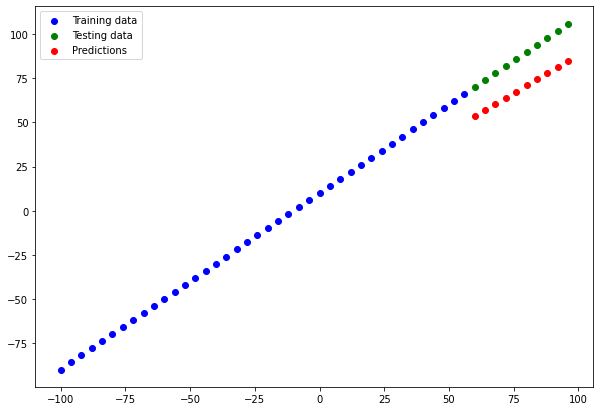

In [ ]:
# Make and plot predictions for model_1
y_preds_1 = model_1.predict(X_test)
plot_predictions(predictions=y_preds_1)

In [ ]:
# Calculate model_1 metrics
mae_1 = mae(y_test, y_preds_1.squeeze()).numpy()
mse_1 = mse(y_test, y_preds_1.squeeze()).numpy()
mae_1, mse_1

(18.745327, 353.57336)

`model_2`

Bu sefer ekstra yoğun bir katman ekleyeceğiz (böylece artık modelimiz 2 katmana sahip olacak), diğer her şeyi aynı tutacağız.


In [ ]:
# Set random seed
tf.random.set_seed(42)

# Replicate model_1 and add an extra layer
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1) # add a second layer
])

# Compile the model
model_2.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Fit the model
model_2.fit(X_train, y_train, epochs=100, verbose=0) # set verbose to 0 for less output

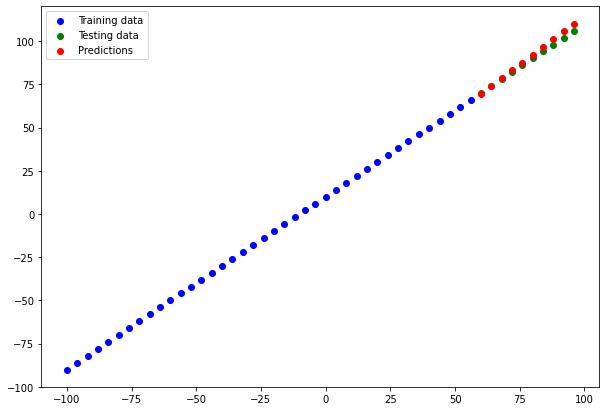

In [ ]:
# Make and plot predictions for model_2
y_preds_2 = model_2.predict(X_test)
plot_predictions(predictions=y_preds_2)

Woah, bu şimdiden daha iyi görünüyor! Ve tek gereken ekstra bir katmandı.

In [ ]:
# Calculate model_2 metrics
mae_2 = mae(y_test, y_preds_2.squeeze()).numpy()
mse_2 = mse(y_test, y_preds_2.squeeze()).numpy()
mae_2, mse_2

(1.9098114, 5.459232)

`model_3`

3.modelimiz için her şeyi model_2 ile aynı tutacağız, ancak bu sefer daha uzun antrenman yapacağız (100 yerine 500 dönem).

Bu, modelimize verilerdeki kalıpları öğrenme şansı verecektir.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Replicate model_2
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1)
])

# Compile the model
model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Fit the model (this time for 500 epochs, not 100)
model_3.fit(X_train, y_train, epochs=500, verbose=0) # set verbose to 0 for less output

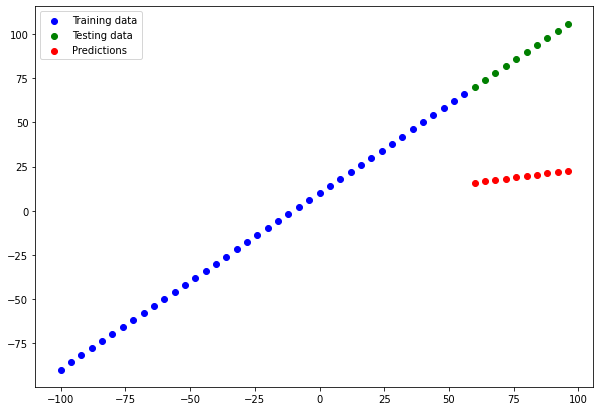

In [ ]:
# Make and plot predictions for model_3
y_preds_3 = model_3.predict(X_test)
plot_predictions(predictions=y_preds_3)

Garip, daha uzun süre çalıştık ama modelimiz daha mı kötü performans gösterdi?

Görünen o ki, modelimiz çok uzun süre eğitilmiş ve bu nedenle daha kötü sonuçlara yol açmış olabilir (daha sonra eğitimi çok uzun süre engellemenin yollarını göreceğiz).

In [ ]:
# Calculate model_3 metrics
mae_3 = mae(y_test, y_preds_3.squeeze()).numpy()
mse_3 = mse(y_test, y_preds_3.squeeze()).numpy()
mae_3, mse_3

(68.68786, 4804.4717)

### sonuçları karşılaştırma
Şimdi 3 benzer ama biraz farklı sonuç için sonuçlarımız var, bunları karşılaştıralım.

In [ ]:
model_results = [["model_1", mae_1, mse_1],
                 ["model_2", mae_2, mse_2],
                 ["model_3", mae_3, mse_3]]

In [ ]:
import pandas as pd
all_results = pd.DataFrame(model_results, columns=["model", "mae", "mse"])
all_results

,model,mae,mse
0,model_1,18.745327,353.573364
1,model_2,1.909811,5.459232
2,model_3,68.687859,4804.471680


Deneylerimizden en iyi performansı model_2 gibi görünüyor.

Ve şimdi, "vay, modelleri karşılaştırmak sıkıcı..." diye düşünebilirsiniz ve kesinlikle olabilir, burada sadece 3 modeli karşılaştırdık.

Ancak bu, birçok farklı model kombinasyonunu denemek ve hangisinin en iyi performansı gösterdiğini görmek, makine öğrenimi modellemesinin neyle ilgili olduğunun bir parçasıdır.

Oluşturduğunuz her model küçük bir deneydir.

🔑 **Not**: Ana hedeflerinizden biri, deneyleriniz arasındaki süreyi en aza indirmek olmalıdır. Ne kadar çok deney yaparsanız, hangilerinin işe yaramadığını o kadar çok anlarsınız ve sırayla neyin işe yaradığını bulmaya yaklaşırsınız. Makine öğrenimi uygulayıcısının sloganını hatırlayın: "deney, deney, deney".

Ayrıca bulacağınız başka bir şey de işe yarayacağını düşündüğünüz şeyin (bir modeli daha uzun süre eğitmek gibi) her zaman işe yaramayabilir ve çoğu zaman tam tersi de geçerlidir.


### Denemelerinizi izleme

Gerçekten iyi bir alışkanlık, hangisinin diğerlerinden daha iyi performans gösterdiğini görmek için modelleme deneylerinizi takip etmektir.

Yukarıda bunun basit bir versiyonunu yaptık (sonuçları farklı değişkenlerde tutarak).

> 📖 Kaynak: Ancak daha fazla model oluşturduğunuzda, aşağıdaki gibi araçları kullanmak isteyeceksiniz:

- **[TensorBoard](https://tensorboard.dev/)** - TensorFlow kitaplığının modelleme deneylerini izlemeye yardımcı olan bir bileşeni (bunu daha sonra göreceğiz).
- **[Weights & Biases](https://wandb.ai/site)** - her türlü makine öğrenimi deneyini izlemek için bir araç (Weights & Biases için iyi haber, TensorBoard'a bağlanmasıdır).

## Bir modeli kaydetme

Bir modeli eğittiğinizde ve beğeninize uygun bir model bulduğunuzda, muhtemelen onu başka bir yerde (bir web uygulaması veya mobil cihaz gibi) kullanmak üzere kaydetmek isteyeceksiniz.

`model.save()` kullanarak bir TensorFlow/Keras modelini kaydedebilirsiniz.

TensorFlow'da bir modeli kaydetmenin iki yolu vardır:

- [SavedModel](https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format) biçimi (varsayılan).
- [HDF5](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format) formatı.

İkisi arasındaki temel fark, SavedModel'in, modeli tekrar yüklerken ek değişiklikler yapmadan özel nesneleri (özel katmanlar gibi) otomatik olarak kaydedebilmesidir.

Hangisini kullanmalısınız?

Durumunuza bağlıdır ancak SavedModel formatı çoğu zaman yeterli olacaktır.

Her iki yöntem de aynı yöntem çağrısını kullanır.

In [ ]:
# Save a model using the SavedModel format
model_2.save('best_model_SavedModel_format')

INFO:tensorflow:Assets written to: best_model_SavedModel_format/assets


In [ ]:
# Check it out - outputs a protobuf binary file (.pb) as well as other files
!ls best_model_SavedModel_format

Şimdi modeli HDF5 formatında kaydedelim, aynı yöntemi kullanacağız ama farklı bir dosya adıyla.

In [ ]:
# Save a model using the HDF5 format
model_2.save("best_model_HDF5_format.h5") # note the addition of '.h5' on the end

In [ ]:
# Check it out
!ls best_model_HDF5_format.h5

## Model Yükleme

`load_model()` yöntemini kullanarak kaydedilmiş bir modeli yükleyebiliriz.

Farklı biçimler (SavedModel ve HDF5) için bir model yüklemek aynıdır (belirli biçimlerin yol adları doğru olduğu sürece).

In [ ]:
# Load a model from the SavedModel format
loaded_saved_model = tf.keras.models.load_model("best_model_SavedModel_format")
loaded_saved_model.summary()

Şimdi test edelim.

In [ ]:
# Compare model_2 with the SavedModel version (should return True)
model_2_preds = model_2.predict(X_test)
saved_model_preds = loaded_saved_model.predict(X_test)
mae(y_test, saved_model_preds.squeeze()).numpy() == mae(y_test, model_2_preds.squeeze()).numpy()

HDF5'ten yükleme yapmak hemen hemen aynı.

In [ ]:
# Load a model from the HDF5 format
loaded_h5_model = tf.keras.models.load_model("best_model_HDF5_format.h5")
loaded_h5_model.summary()

In [ ]:
# Compare model_2 with the loaded HDF5 version (should return True)
h5_model_preds = loaded_h5_model.predict(X_test)
mae(y_test, h5_model_preds.squeeze()).numpy() == mae(y_test, model_2_preds.squeeze()).numpy()

## Bir model indirme (Google Colab'dan)

Modelinizi Google Colab'dan yerel makinenize almak istediğinizi varsayalım, aşağıdakilerden birini yapabilirsiniz:

Dosyalar bölmesinde dosyaya sağ tıklayın ve 'indir' seçeneğine tıklayın.
Aşağıdaki kodu kullanın.

## Daha büyük bir örnek

Pekala, TensorFlow'da sinir ağı regresyon modelleri oluşturmanın temellerini gördük.

Bir adım öteye gidelim ve daha zengin özelliklere sahip bir veri için bir model oluşturalım.

Daha spesifik olarak, yaş, cinsiyet, vücut ağırlığı, çocuklar, sigara içme durumu ve yerleşim bölgesi gibi bir dizi farklı parametreye dayalı olarak bireyler için sağlık sigortası maliyetini tahmin etmeye çalışacağız.

Bunu yapmak için, Kaggle'da bulunan ve GitHub'da barındırılan, herkesin kullanımına açık Tıbbi Maliyet veri kümesinden yararlanacağız.

> 🔑 Not: Makine öğrenimi paradigmalarını öğrenirken, genellikle bir dizi temel teknikten geçer ve ardından açık kaynaklı veri kümeleri ve örneklerle çalışarak bunları uygularsınız. Tıpkı şimdi yaptığımız gibi, temelleri öğrenin, onları farklı problemlerle çalıştırın. Her yeni bir şey üzerinde çalıştığınızda, probleminiz için X yerine "Python/TensorFlow ile problem X örneği" gibi bir şey aramak iyi bir fikirdir.

In [ ]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [ ]:
# Check out the insurance dataset
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Sayısal olmayan sütunları sayılara çevirmemiz gerekecek (çünkü bir sinir ağı sayısal olmayan girdileri işleyemez).

Bunu yapmak için pandalarda get_dummies() yöntemini kullanacağız.

Tek-sıcak kodlamayı kullanarak kategorik değişkenleri (cinsiyet, sigara içen ve bölge sütunları gibi) sayısal değişkenlere dönüştürür.

In [ ]:
# Turn all categories into numbers
insurance_one_hot = pd.get_dummies(insurance)
insurance_one_hot.head() # view the converted columns

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


Şimdi verileri özellikler (X) ve etiketler (y) olarak ayıracağız.

In [ ]:
# Create X & y values
X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

In [ ]:
# View features
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


Ve eğitim ve test setleri oluşturun. Bunu manuel olarak yapabiliriz, ancak kolaylaştırmak için Scikit-Learn'de zaten mevcut olan train_test_split işlevinden yararlanacağız.

In [ ]:
# Create training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42) # set random state for reproducible splits

Şimdi bir model oluşturup sığdırabiliriz (bunu model_2 ile aynı yapacağız).

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a new model (same as model_2)
insurance_model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model.compile(loss=tf.keras.losses.mae,
                        optimizer=tf.keras.optimizers.SGD(),
                        metrics=['mae'])

# Fit the model
insurance_model.fit(X_train, y_train, epochs=100, verbose=0)

In [ ]:
# Check the results of the insurance model
insurance_model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 8628.2393 - mae: 8628.2393


[8628.2392578125, 8628.2392578125]

Modelimiz pek iyi performans göstermedi, hadi daha büyük bir model deneyelim.

3 şey deneyeceğiz:

- Katman sayısını artırma (2 -> 3).
- Her katmandaki birim sayısını artırma (çıktı katmanı hariç).
- Optimize ediciyi değiştirme (SGD'den Adam'a).

Diğer her şey aynı kalacak.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Add an extra layer and increase number of units
insurance_model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(100), # 100 units
  tf.keras.layers.Dense(10), # 10 units
  tf.keras.layers.Dense(1) # 1 unit (important for output layer)
])

# Compile the model
insurance_model_2.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(), # Adam works but SGD doesn't 
                          metrics=['mae'])

# Fit the model and save the history (we can plot this)
history = insurance_model_2.fit(X_train, y_train, epochs=100, verbose=0)

In [ ]:
# Evaluate our larger model
insurance_model_2.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 4924.3477 - mae: 4924.3477


[4924.34765625, 4924.34765625]

Çok daha iyi! Daha büyük bir model ve Adam optimize edici kullanmak, önceki modele göre neredeyse yarı yarıya hatayla sonuçlanır.

> 🔑 Not: Birçok sorun için Adam optimize edici harika bir başlangıç ​​seçimidir. Daha fazlası için [A Recipe for Training Neural Networks](http://karpathy.github.io/2019/04/25/recipe/)'den Andrei Karpathy'nin "Adam güvende" noktasına bakın.

Modelimizin kayıp eğrilerine bir göz atalım, aşağı yönlü bir trend görmeliyiz.

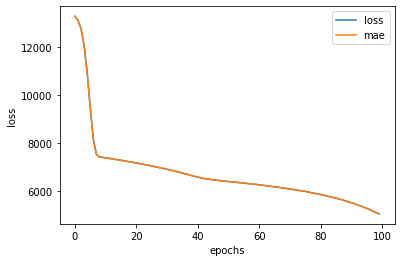

In [ ]:
# Plot history (also known as a loss curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

Buradan, modelimizin kaybının (ve MAE) her ikisinin de hala azalmakta olduğu görülüyor (bizim durumumuzda, MAE ve kayıp aynı, dolayısıyla arsadaki çizgiler birbiriyle örtüşüyor).

Bunun bize söylediği şey, onu daha uzun süre eğitmeye çalışırsak kaybın düşebileceğidir.

> 🤔 Soru: Ne kadar süre antrenman yapmalısınız?

> Hangi sorun üzerinde çalıştığınıza bağlı. Bazen eğitim çok uzun sürmez, bazen beklediğinizden daha uzun sürer. Yaygın bir yöntem, model eğitiminizi çok uzun bir süre için ayarlamaktır (ör. 1000'lerce epoch), ancak bunu bir [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) geri çağrısı ile ayarlamaktır, böylece gelişmeyi bıraktığında otomatik olarak durur. Bunu başka bir modülde göreceğiz.

Yukarıdaki modeli biraz daha uzun süre eğitelim. Bunu yapabiliriz ama tekrar uygun diyoruz.

In [ ]:
# Try training for a little longer (100 more epochs)
history_2 = insurance_model_2.fit(X_train, y_train, epochs=100, verbose=0)

Ekstra eğitim nasıl geçti?

In [ ]:
# Evaluate the model trained for 200 total epochs
insurance_model_2_loss, insurance_model_2_mae = insurance_model_2.evaluate(X_test, y_test)
insurance_model_2_loss, insurance_model_2_mae

9/9 [==============================] - 0s 1ms/step - loss: 3494.7285 - mae: 3494.7285


(3494.728515625, 3494.728515625)

Boom! Fazladan 100 dönemlik eğitim, hatada yaklaşık %10'luk bir azalma görüyoruz.

Görsel nasıl görünüyor?

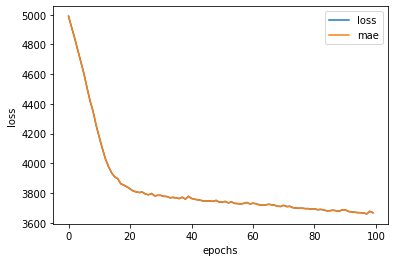

In [ ]:
# Plot the model trained for 200 total epochs loss curves
pd.DataFrame(history_2.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs"); # note: epochs will only show 100 since we overrid the history variable

## Ön işleme verileri (normalleştirme ve standardizasyon)

Sinir ağlarıyla çalışırken yaygın bir uygulama, onlara ilettiğiniz tüm verilerin 0 ila 1 aralığında olduğundan emin olmaktır.

Bu uygulamaya normalleştirme denir (tüm değerleri orijinal aralıklarından 0 ile 100.000 arasında 0 ile 1 arasında olacak şekilde ölçeklendirmek).

Tüm verilerinizi birim varyansa ve 0 ortalamaya dönüştüren başka bir işlem çağrısı standardizasyonu vardır.

Bu iki uygulama genellikle bir ön işleme hattının (verilerinizi sinir ağlarıyla kullanıma hazırlamak için bir dizi işlev) parçasıdır.

Bunu bilerek, bir sinir ağı için verilerinizi önceden işlemek üzere atacağınız bazı önemli adımlardan bazıları şunlardır:

- Tüm verilerinizi sayılara çevirmek (bir sinir ağı dizeleri işleyemez).
- Verilerinizin doğru şekilde olduğundan emin olun (giriş ve çıkış şekillerini doğrulama).
- Özellik ölçeklendirme:
  - Verileri normalleştirme (tüm değerlerin 0 ile 1 arasında olduğundan emin olun). Bu, minimum değerin çıkarılması ve ardından maksimum değerin minimumdan çıkarılmasıyla yapılır. Bu aynı zamanda min-maks ölçekleme olarak da adlandırılır.
  - Standardizasyon (tüm değerlerin ortalamasının 0 ve varyansının 1 olduğundan emin olun). Bu, ortalama değerin hedef özellikten çıkarılması ve ardından standart sapmaya bölünmesiyle yapılır.
  - Hangisini kullanmalısınız?
    - Sinir ağlarında, 0 ile 1 arasındaki değerleri tercih etme eğiliminde oldukları için normalleştirmeyi tercih edeceksiniz (bunu özellikle görüntü işlemede göreceksiniz), ancak genellikle bir sinir ağının minimum özellik ölçekleme ile oldukça iyi performans gösterebileceğini göreceksiniz.


> 📖 Kaynak: Ön işleme verileri hakkında daha fazla bilgi için aşağıdaki kaynakları okumanızı tavsiye ederim:

* [Scikit-Learn'ün ön işleme verileriyle ilgili belgeleri.](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-data)
* [Jeff Hale'den Scikit-Learn ile Ölçeklendirin, Standartlaştırın veya Normalleştirin.](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)

Verilerimizi `get_dummies()` kullanarak zaten sayılara dönüştürdük, bakalım nasıl normalleştireceğimize de bakalım.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [ ]:
# Check out the data
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Şimdi, daha önce olduğu gibi, sayısal olmayan sütunları sayılara dönüştürmemiz gerekiyor ve bu sefer de sayısal sütunları farklı aralıklarla normalleştireceğiz (hepsinin 0 ile 1 arasında olduğundan emin olmak için).

Bunu yapmak için Scikit-Learn'den birkaç sınıf kullanacağız:

- make_column_transformer - aşağıdaki dönüşümler için çok adımlı bir veri ön işleme işlevi oluşturun:
  - MinMaxScaler - tüm sayısal sütunların normalleştirildiğinden emin olun (0 ile 1 arasında).
  - OneHotEncoder - bir sıcak sayısal olmayan sütunları kodlar.


In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

# Create X & y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

Şimdi onu normalleştirdik ve tek seferde kodladık, verilerimiz şimdi nasıl görünüyor?

In [ ]:
# Non-normalized and non-one-hot encoded data example
X_train.loc[0]

age                19
sex            female
bmi              27.9
children            0
smoker            yes
region      southwest
Name: 0, dtype: object

In [ ]:
# Normalized and one-hot encoded example
X_train_normal[0]

array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        ])

In [ ]:
# Notice the normalized/one-hot encoded shape is larger because of the extra columns
X_train_normal.shape, X_train.shape

((1070, 11), (1070, 6))

Verilerimiz normalize edilmiş ve sayısaldır, hadi modelleyelim.

Sigorta_model_2 ile aynı modeli kullanacağız.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Build the model (3 layers, 100, 10, 1 units)
insurance_model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model_3.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
insurance_model_3.fit(X_train_normal, y_train, epochs=200, verbose=0) 

In [ ]:
# Evaulate 3rd model
insurance_model_3_loss, insurance_model_3_mae = insurance_model_3.evaluate(X_test_normal, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 3171.5774 - mae: 3171.5774


Ve son olarak, sigorta_model_2 (normalleştirilmemiş veriler üzerinde eğitilmiş) ve sigorta_model_3 (normalleştirilmiş veriler üzerinde eğitilmiş) sonuçlarını karşılaştıralım.

In [ ]:
# Compare modelling results from non-normalized data and normalized data
insurance_model_2_mae, insurance_model_3_mae

(3494.728515625, 3171.577392578125)

Bundan, verileri normalleştirmenin, aynı modeli kullanarak verileri normalleştirmemeye göre %10 daha az hatayla sonuçlandığını görebiliriz.

Bu, normalleştirmenin ana faydalarından biridir: daha hızlı yakınsama süresi (söylemenin süslü bir yolu, modeliniz daha hızlı daha iyi sonuçlara ulaşır).

insurance_model_2, eğitimini daha uzun süre bırakırsak, sonunda insurance_model_3 ile aynı sonuçları elde etmiş olabilir.

Ayrıca, modellerin mimarilerini değiştirecek olursak sonuçlar değişebilir, örn. katman veya daha fazla katman başına daha fazla gizli birim.

Ancak sinir ağı uygulayıcıları olarak asıl amacımız deneyler arasındaki süreyi azaltmak olduğundan, daha iyi sonuçları daha erken almamıza yardımcı olan her şey bir artıdır.

---

## 🛠 Egzersizler

Oldukça hızlı bir şekilde bir çok şeyi ele aldık.

Şimdi birkaç şeyle oynamanın ve inisiyasyonunuzu oluşturmaya başlamanın zamanı geldi.

Kelimelerin ortalıkta dolaştığını vurguluyorum çünkü bu çok önemli. Birkaç şey deneyin, kodu çalıştırın ve ne olduğunu görün.

1. Kendi regresyon veri kümenizi oluşturun (veya "Görüntülemek ve sığdırmak için veri oluşturma" bölümünde oluşturduğumuzu daha büyük yapın) ve buna uygun bir model oluşturun.

2. 4 Yoğun katman içeren bir sinir ağı oluşturmayı ve bunu kendi regresyon veri kümenize uydurmayı deneyin, nasıl performans gösteriyor?

3. Sigorta veri setinde elde ettiğimiz sonuçları deneyin ve iyileştirin, denemek isteyebileceğiniz bazı şeyler şunlardır:
  - Daha büyük bir model oluşturmak (4 yoğun katmana sahip olan nasıl olur?).
  - Her katmandaki birim sayısını artırmak.
  - Adam'ın belgelerine bakın ve ilk parametrenin ne olduğunu öğrenin, 10 kat arttırırsanız ne olur?
  - Daha uzun süre çalışırsanız ne olur (örneğin 200 yerine 300 dönem)?

In [281]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [337]:
X = np.arange(0, 100, 5)
y = np.array([x*5 + 2 for x in X])

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

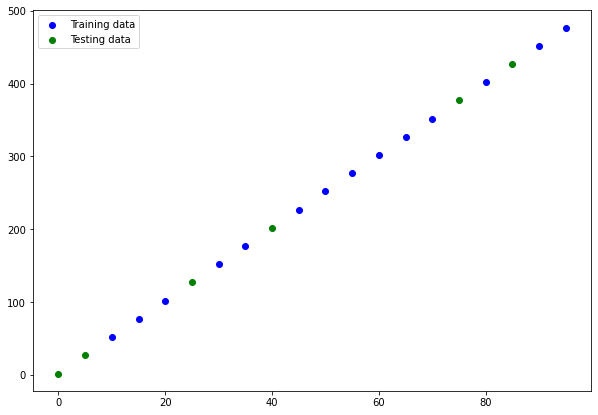

In [338]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, c='b', label='Training data')
plt.scatter(X_test, y_test, c='g', label='Testing data')
plt.legend();

In [339]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(500),
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1),
])

model.compile(loss=tf.keras.losses.mae, 
              optimizer=tf.keras.optimizers.Adam(
                  learning_rate=0.001,
              ),
              metrics=["mae"])

# Fit the model
model.fit(X_train, y_train, epochs=300, verbose=0)
# plot_model(model, show_shapes=True)

In [340]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 99ms/step - loss: 1.1367 - mae: 1.1367


[1.1366502046585083, 1.1366502046585083]

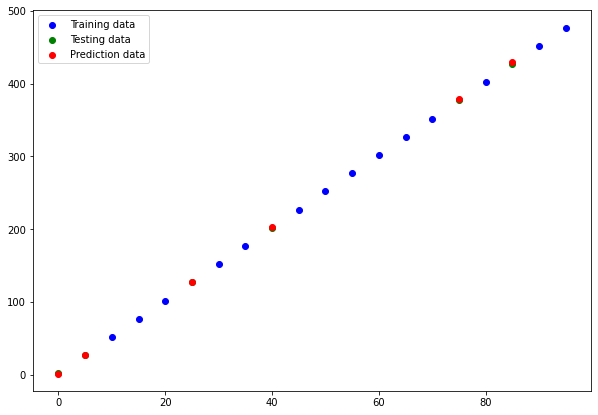

In [341]:
y_preds = model.predict(X_test)

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, c='b', label='Training data')
plt.scatter(X_test, y_test, c='g', label='Testing data')
plt.scatter(X_test, y_preds, c='r', label='Prediction data')
plt.legend();

In [347]:
mae = tf.metrics.mean_absolute_error(y_true=y_test, 
                                     y_pred=y_preds.squeeze())
mse = tf.metrics.mean_squared_error(y_true=y_test,
                                    y_pred=y_preds.squeeze())
print("mse: ", mse.numpy())
print("mae: ", mae.numpy())

mse:  2.2184865
mae:  1.1366515


4. [Boston fiyatlandırma veri kümesini](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/boston_housing/load_data) TensorFlow tf.keras.datasets'ten içe aktarın ve modelleyin.

In [356]:
(X_train,y_train ), (X_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', test_split=0.2, seed=113
)

In [359]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(500),
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1),
])

model.compile(loss=tf.keras.losses.mae, 
              optimizer=tf.keras.optimizers.Adam(
                  learning_rate=0.001,
              ),
              metrics=["mae"])

model.fit(X_train, y_train, epochs=300, verbose=0)

In [360]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 3.8578 - mae: 3.8578


[3.857836961746216, 3.857836961746216]

In [376]:
y_preds = model.predict(X_test)
tf.metrics.mean_absolute_error(y_test, y_preds.squeeze())

<tf.Tensor: shape=(), dtype=float32, numpy=3.857837>